# Paper Trading with Python and Binance - the Spot Testnet API

More Information and getting the Credentials: https://testnet.binance.vision/

__Insert your Spot Testnet Credentials here__:

In [ ]:
api_key = "insert_here"
secret_key = "insert_here"

## Creating a Connection to the Spot Testnet

In [ ]:
from binance.client import Client

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) # Testnet!!!

__Simple Rule:__ <br>
Use your __Testnet Credentials with testnet = True__ and your __"Real Account" Credentials with testnet = False__ (default)

In [ ]:
client

In [ ]:
client.get_account() # Test account details

## Spot Testnet API - Overview

__Same Documentation applies for Spot Testnet:__

https://binance-docs.github.io/apidocs/spot/en/#introduction

In [ ]:
import pandas as pd
from binance.client import Client

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) # Testnet!!!

In [ ]:
client.get_system_status()

In [ ]:
account = client.get_account()
account

In [ ]:
df = pd.DataFrame(account["balances"])
df

In [ ]:
df.free = pd.to_numeric(df.free, errors = "coerce")
df.locked = pd.to_numeric(df.locked, errors = "coerce")

In [ ]:
df.info()

In [ ]:
client.get_asset_balance(asset = "BTC")

In [ ]:
client.get_asset_balance(asset = "ETH")

In [ ]:
client.get_asset_balance(asset = "EUR")

In [ ]:
client.get_symbol_ticker(symbol = "BTCUSDT") # current price for one symbol

In [ ]:
# get current prices for all pairs
client.get_all_tickers()

In [ ]:
last24 = client.get_ticker(symbol = "BTCUSDT") # 24H Price change statistic
last24

In [ ]:
timestamp = client._get_earliest_valid_timestamp(symbol = "BTCUSDT", interval = "1d")
timestamp

In [ ]:
pd.to_datetime(timestamp, unit = "ms") # reset every month!!!

In [ ]:
def get_history(symbol, interval, start, end = None):
    bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                        start_str = start, end_str = end, limit = 1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
    
    return df

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1d", start = timestamp)
df

In [ ]:
df = get_history(symbol = "BTCUSDT", interval = "1h", start = "2021-09-15")
df

### ++++++ Update (August 2023) ++++++++

There are two alterantives to stream live data with python-binance:
- using __ThreadedWebsocketManager__ -or-
- using __BinanceSocketManager (newly added to the course)__

__What´s the benefit of covering both options?__<br>
-> We can now __run Trading Bots in Jupyter and as a Script__ with the __latest Versions__ for Python and Python-Binance. No need to care about Versions and Installations anymore!

For more information, please go back to the previous Lectures (API Intro)!

### Option 1: ThreadedWebsocketManager (only executable in scripts, not in Jupyter!):

In [ ]:
from binance import ThreadedWebsocketManager

In [ ]:
def stream_data(msg):
    ''' define how to process incoming WebSocket messages '''
    
    time = pd.to_datetime(msg["E"], unit = "ms")
    price = msg["c"]
    
    print("Time: {} | Price: {}".format(time, price))

In [ ]:
# initialize and start the WebSocket
twm = ThreadedWebsocketManager()
twm.start()

In [ ]:
# subscribe to the stream
twm.start_symbol_miniticker_socket(callback = stream_data, symbol = "BTCUSDT")

In [ ]:
# stop the Websocket/Stream after 20 seconds
while True:
    time.sleep(20)
    twm.stop()
    break

---------------------------

### Option 2: BinanceSocketManager (executable in Jupyter!):

In [ ]:
stream_data

In [ ]:
import asyncio
from binance import AsyncClient, BinanceSocketManager

In [ ]:
async def main():
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client)
    ts = bm.symbol_miniticker_socket(symbol = "BTCUSDT")
    
    async with ts as tscm:
        for _ in range(10):
            res = await tscm.recv()
            stream_data(res)

    await client.close_connection()
await main()

## Placing a Market Buy Order

In [ ]:
from binance.client import Client
import pandas as pd

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) 

In [ ]:
client.get_account() 

In [ ]:
# buy 0.1 BTC
order = client.create_order(symbol = "BTCUSDT", side = "BUY", type = "MARKET", quantity = 0.1)

In [ ]:
order

In [ ]:
df = pd.DataFrame(order["fills"])
df

In [ ]:
df.info()

In [ ]:
num_columns = ["price", "qty", "commission"]

In [ ]:
for column in num_columns:
    df[column] = pd.to_numeric(df[column], errors = "coerce")

In [ ]:
df.info()

In [ ]:
df.qty.sum()

In [ ]:
df.price.mul(df.qty).sum()

In [ ]:
client.get_account()

In [ ]:
# buy BTC for 1,000 USDT 
order = client.create_order(symbol = "BTCUSDT", side = "BUY", type = "MARKET", quoteOrderQty = 1000)

In [ ]:
order

In [ ]:
avr_price = float(order["cummulativeQuoteQty"]) / float(order["origQty"]) 
avr_price

In [ ]:
client.get_account()

## Placing a Market Sell Order

In [ ]:
# selling 0.118011 BTC 
order = client.create_order(symbol = "BTCUSDT", side = "SELL", type = "MARKET", quantity = 0.1)

In [ ]:
order

In [ ]:
client.get_account() # Test account details

## Placing Limit Orders

In [ ]:
from binance.client import Client
import pandas as pd

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) 

In [ ]:
client.get_account()

In [ ]:
client.get_symbol_ticker(symbol = "BTCUSDT") # current price

__Limit Buy Order__

In [ ]:
order1 = client.create_order(symbol="BTCUSDT", side = "BUY", type = "LIMIT",
                            quantity = 0.1, timeInForce = "GTC", price = 50000)

In [ ]:
order1

In [ ]:
order_id_buy = order1["orderId"]
order_id_buy

In [ ]:
client.get_order(symbol = "BTCUSDT", orderId = order_id_buy)

__Limit Sell Order__

In [ ]:
order2 = client.create_order(symbol="BTCUSDT", side = "SELL", type = "LIMIT",
                            quantity = 0.1, timeInForce = "GTC", price = 60000)

In [ ]:
order2

In [ ]:
order_id_sell = order2["orderId"]
order_id_sell

In [ ]:
open_orders = client.get_open_orders(symbol = "BTCUSDT")
open_orders

In [ ]:
pd.DataFrame(open_orders)

In [ ]:
result = client.cancel_order(symbol = "BTCUSDT", orderId = order_id_buy)
result

In [ ]:
result = client.cancel_order(symbol = "BTCUSDT", orderId = order_id_sell)
result

## Reporting: Getting all (historical) Orders and Trades

In [ ]:
from binance.client import Client
import pandas as pd

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) 

In [ ]:
all_orders = client.get_all_orders(symbol = "BTCUSDT")
all_orders

In [ ]:
pd.DataFrame(all_orders)

In [ ]:
trades = client.get_my_trades(symbol = "BTCUSDT")
trades

In [ ]:
df = pd.DataFrame(trades)
df

In [ ]:
df.time = pd.to_datetime(df.time, unit = "ms", errors = "coerce")

In [ ]:
df

## Creating & Running a first (simple) Trading Bot

In [ ]:
from binance.client import Client
import pandas as pd

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True)

In [ ]:
client.get_account()

### Random Trading Bot

__A simple random Trading Bot__: Stream Market Data and buy 0.1 BTC (with USDT) once condition x (Price and/or Volume) has been met. Then stop the Stream.

Condition x: Price (rounded down) is divisible by 10 without remainder.

In [ ]:
40215 % 10 # modulo

__Using the Miniticker Stream:__

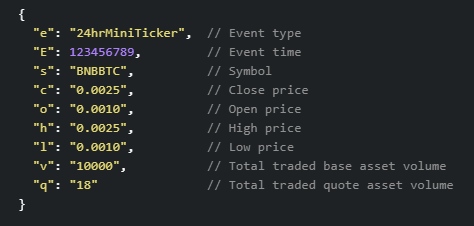

### Option 1: ThreadedWebsocketManager (only executable in scripts, not in Jupyter!):

In [ ]:
from binance import ThreadedWebsocketManager

In [ ]:
twm = ThreadedWebsocketManager()
twm.start()

In [ ]:
def simple_bot(msg):
    ''' define how to process incoming WebSocket messages '''
    
    time = pd.to_datetime(msg["E"], unit = "ms")
    price = float(msg["c"])
    
    print("Time: {} | Price: {}".format(time, price))
    
    if int(price) % 10 == 0:
        order = client.create_order(symbol = "BTCUSDT", side = "BUY", type = "MARKET", quantity = 0.1)
        print("\n" + 50 * "-")
        print("Buy {} BTC for {} USDT".format(order["executedQty"], order["cummulativeQuoteQty"]))
        print(50 * "-" + "\n")
        
        twm.stop() # stop defined inside callback

In [ ]:
twm.start_symbol_miniticker_socket(callback = simple_bot, symbol = "BTCUSDT")
twm.join() # required if stop is defined in callback function

-----------------------------

### Option 2: BinanceSocketManager (executable in Jupyter!): 

In [ ]:
import asyncio
from binance import AsyncClient, BinanceSocketManager

In [ ]:
stop_streaming = False # setting a stop_streaming variable (initially: False)

In [ ]:
def simple_bot(msg):
    ''' define how to process incoming WebSocket messages '''
    
    time = pd.to_datetime(msg["E"], unit = "ms")
    price = float(msg["c"])
    
    print("Time: {} | Price: {}".format(time, price))
    
    if int(price) % 10 == 0:
        order = client.create_order(symbol = "BTCUSDT", side = "BUY", type = "MARKET", quantity = 0.1)
        print("\n" + 50 * "-")
        print("Buy {} BTC for {} USDT".format(order["executedQty"], order["cummulativeQuoteQty"]))
        print(50 * "-" + "\n")
        
        global stop_streaming
        stop_streaming = True  # stop defined inside callback

In [ ]:
async def main():
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client)
    ts = bm.symbol_miniticker_socket(symbol="BTCUSDT")
    
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            simple_bot(res)
            
            if stop_streaming:
                break

    await client.close_connection()

In [ ]:
await main()

In [ ]:
client.get_account() 